# UBI Funding Sources

This document evaluates possible funding sources for UBI by broadening the base of taxation.

## Personal Allowance

### Current system


The Personal Allowance is an allowance for most UK individuals, deductible from all forms of income. It is the largest and fastest-growing allowance in the tax code, with most of its gains seen during the Coalition government of 2010-2015, and currently stands at £12,570.

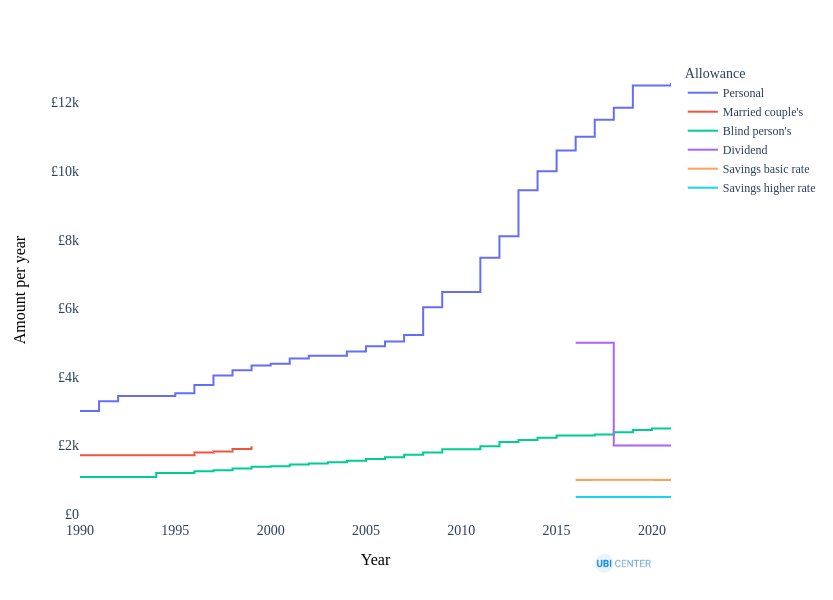

In [1]:
import plotly.express as px
from ubicenter import format_fig as format_fig
import pandas as pd

historical = pd.read_csv("data/external/historical_allowances.csv")
historical["Year"] = list(range(1990, 2022))
historical.columns = list(map(lambda col: col.split(" (note")[0], historical.columns))
historical = historical.apply(lambda col: col.apply(lambda value: float(str(value).split(" ")[0].replace(",", ""))))
fig = format_fig(px.line(
    historical, 
    x="Year", 
    y=["Personal", "Married couple's", "Blind person's", "Dividend", "Savings basic rate", "Savings higher rate"],
    line_shape="hv"
).update_layout(
    legend_title="Allowance",
    yaxis_title="Amount per year",
    yaxis_tickprefix="£",
), show=False)
from pathlib import Path
IMAGES = Path("images")
TABLES = Path("tables")
fig.write_image(IMAGES / "fig_1.png")
fig

The Personal Allowance is applicable to the vast majority of UK individuals, but it is means-tested: individuals with an adjusted net income (taxable income) of over £100,000 begin to see their Personal Allowance phased out at a rate of 50% as they increase earnings. This saves a small amount of revenue but at the cost of a decrease to work incentives in the region. The Personal Allowance also reduces marginal tax rates at the lower end of the income spectrum, but the effect is smaller as reductions in tax MTRs are partially offset by increases in benefit phaseout (benefits are paid based on post-tax income, so if tax liability decreases, so does benefit entitlement in most cases).

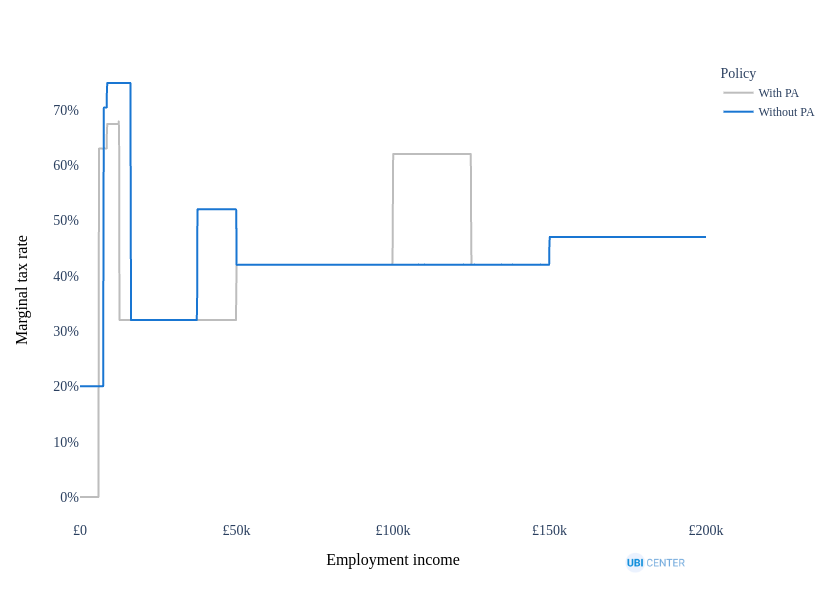

In [2]:
from openfisca_uk import IndividualSim, reforms
from openfisca_uk.situation_examples.examples import single_person_UC
from ubicenter.plotly import BLUE, GRAY
from openfisca_data import FRS_SPI_Adjusted

def get_hypothetical_plots(base, reform, base_name = "Baseline", reform_name = "Reform"):
    reformed = single_person_UC(IndividualSim(reform))
    baseline = single_person_UC(IndividualSim(base))

    baseline.vary("employment_income")
    reformed.vary("employment_income")

    df = pd.DataFrame({
        "Employment income": baseline.calc("employment_income")[0],
        base_name: baseline.calc_mtr(),
        reform_name: reformed.calc_mtr(),
    })

    mtr_fig = format_fig(px.line(df, x="Employment income", y=[base_name, reform_name], color_discrete_sequence=[GRAY, BLUE]).update_layout(
        legend_title="Policy",
        yaxis_tickformat="%",
        yaxis_title="Marginal tax rate",
        xaxis_tickprefix="£"
    ), show=False)
    
    df = pd.DataFrame({
        "Employment income": baseline.calc("employment_income")[0],
        base_name: baseline.calc("household_net_income")[0],
        reform_name: reformed.calc("household_net_income")[0],
    })
    
    budget_fig = format_fig(px.line(df, x="Employment income", y=[base_name, reform_name], color_discrete_sequence=[GRAY, BLUE]).update_layout(
        legend_title="Policy",
        yaxis_tickprefix="£",
        yaxis_title="Household budget",
        xaxis_tickprefix="£"
    ), show=False)
    
    return budget_fig, mtr_fig

budget, mtr = get_hypothetical_plots((), reforms.structural.abolish("personal_allowance"), base_name = "With PA", reform_name = "Without PA")
mtr.write_image(IMAGES / "fig_2.png")
mtr.show()

The Personal Allowance does increase the incomes of those on low incomes (except for non-earners, whom it does not affect), compared to a policy of higher taxation and no additional spending. But the benefit to taxpayers increases with income.

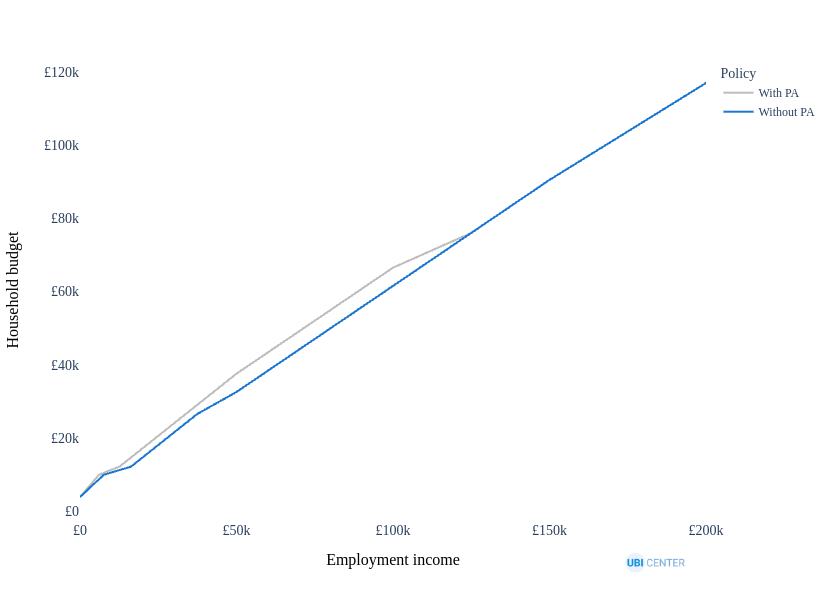

In [3]:
budget.write_image(IMAGES / "fig_3.png")
budget.show()

However, its inclusion in the tax code is disproportionately beneficial in absolute amount to those on higher incomes before the phase-out (due to the fact that it effectively delays the current marginal tax rate schedule, which increases monotonically within the range of the Personal Allowance). Gain relative to income is less regressive but not obviously progressive.

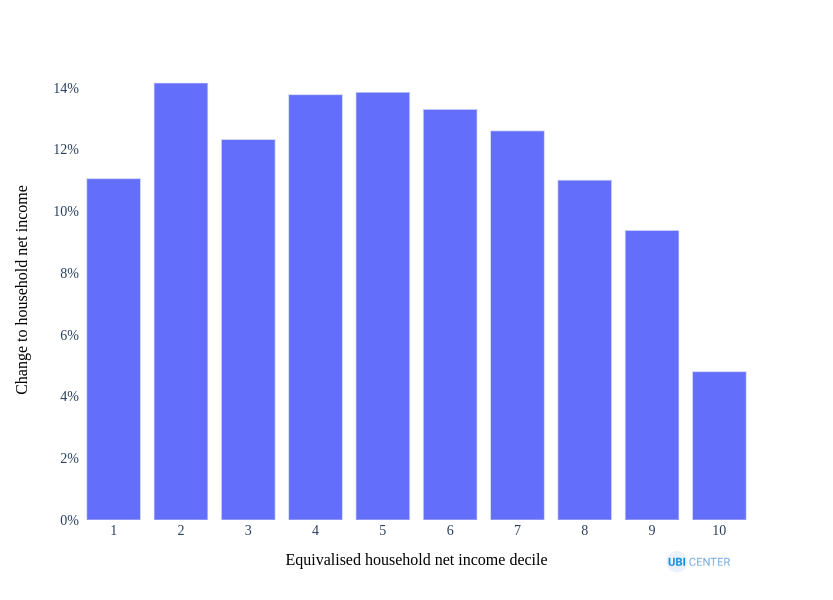

In [4]:
from openfisca_uk import graphs
from openfisca_uk import Microsimulation
from plotly import graph_objects as go

baseline = Microsimulation(reforms.structural.abolish("personal_allowance"), dataset=FRS_SPI_Adjusted)

rel_fig = graphs.decile_chart((), bucket_variable="equiv_household_net_income", change_variable="household_net_income", baseline=baseline, relative=True, microsimulation_kwargs=dict(dataset=FRS_SPI_Adjusted))
fig = format_fig(rel_fig, show=False)
fig.write_image(IMAGES / "fig_4.png")
fig

Overall, the Personal Allowance represents a significant tax cut (over £100bn per year) for UK individuals, and therefore whilst most of its benefits go to the highest incomes, it does still have some antipoverty effects. The below table shows the effects of introducing the Personal Allowance in 2020, from the counterfactual of it not existing. The Personal Allowance is particularly strong at reducing the poverty rate of those over the State Pension Age - primarily due to the fact that the State Pension is taxable, and a significant proportion of income for many. The allowance does recoup a small proportion of its tax expenditure in the form of reduced benefit spending, as individuals' reduced tax liability increases their applicable income, and therefore reduction, in benefit programs.

### UBI Conversion

Repealing the Personal Allowance raises a significant amount of increased tax revenue, posing the question of how the socio-economic effects of this revenue might differ if distributed as a universal basic income, rather than a tax cut. The details of such a UBI policy are simple: each adult and child citizen of the United Kingdom receives an equal payment: a share of the total available funds (maintaining budget neutrality). The static results of such a reform are given in the following table:

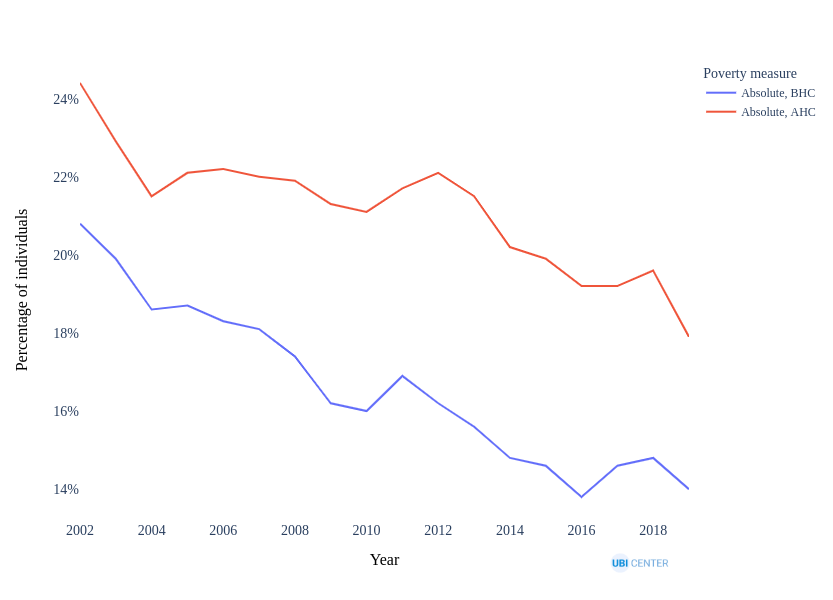

In [17]:
poverty_hbai = pd.read_csv("data/external/poverty_hbai.csv")
poverty_cols = ["Absolute, BHC", "Absolute, AHC"]#, "Relative, BHC", "Relative, AHC"]
for col in poverty_cols:
    poverty_hbai[col] /= 100
poverty_hbai["Year"] = poverty_hbai["Unnamed: 0"]
poverty_hbai.Year = poverty_hbai.Year.apply(lambda x: int(x[:4]))
fig = format_fig(px.line(
    poverty_hbai, 
    x="Year",
    y=poverty_cols,
    ).update_layout(
        yaxis_tickformat="%",
        yaxis_title="Percentage of individuals",
        legend_title="Poverty measure"
    ), show=False)
fig.write_image(IMAGES / "fig_5.png")
fig

In [6]:
from openfisca_uk.api import *
import pandas as pd

def evaluate_reform(reform, baseline, name="Reform"):
    def round_(x, dp=2, *args):
        try:
            res = round(x, ndigits=dp, *args)
            return '{:.1f}'.format(res)
        except:
            return "-"
    def pct(x):
        if x[0] == 0:
            return "-"
        else:
            return (x[1] - x[0]) / x[0]
    absolute = lambda x: x[1] - x[0]
    def change(f, sim):
        return f(baseline), f(sim)
    reformed = Microsimulation(reform, dataset=FRS_SPI_Adjusted)
    inequality = lambda sim: sim.calc("household_net_income", map_to="person").gini()
    top_10_pct_share = lambda sim: sim.calc("household_net_income", map_to="person").top_10_pct_share()
    p90_10 = lambda sim: sim.calc("household_net_income", map_to="person").quantile(0.9) / sim.calc("household_net_income", map_to="person").quantile(0.1)
    poverty_rate = lambda sim: sim.calc("in_poverty_bhc", map_to="person").mean()
    deep_poverty_rate = lambda sim: sim.calc("in_deep_poverty_bhc", map_to="person").mean()
    adult_poverty_rate = lambda sim: sim.calc("in_poverty_bhc", map_to="person")[baseline.calc("is_WA_adult")].mean()
    senior_poverty_rate = lambda sim: sim.calc("in_poverty_bhc", map_to="person")[baseline.calc("is_SP_age")].mean()
    child_poverty_rate = lambda sim: sim.calc("in_poverty_bhc", map_to="person")[baseline.calc("is_child")].mean()
    poverty_gap = lambda sim: sim.calc("poverty_gap_bhc").sum()
    inequality = lambda sim: sim.calc("household_net_income", map_to="person").gini()
    tax_revenue = lambda sim: sim.calc("tax").sum()
    benefit_spending = lambda sim: sim.calc("benefits").sum()
    winner_share = lambda sim: round(100 * (sim.calc("household_net_income", map_to="person") > baseline.calc("household_net_income", map_to="person")).mean(), 2)
    loser_share = lambda sim: round(100 * (sim.calc("household_net_income", map_to="person") < baseline.calc("household_net_income", map_to="person")).mean(), 2)
    
    metric_fns = [
        inequality,
        p90_10,
        top_10_pct_share,
        poverty_rate,
        deep_poverty_rate,
        adult_poverty_rate,
        senior_poverty_rate,
        child_poverty_rate,
        poverty_gap,
        tax_revenue,
        benefit_spending,
        winner_share,
        loser_share
    ]
    metric_names = [
        ("Distributional", "Gini coefficient"),
        ("Distributional", "P90/P10"),
        ("Distributional", "Top 10% share"),
        ("Poverty", "Overall rate"),
        ("Poverty", "Deep poverty rate"),
        ("Poverty", "Adult poverty rate"),
        ("Poverty", "Senior poverty rate"),
        ("Poverty", "Child poverty rate"),
        ("Poverty", "Poverty gap"),
        ("Fiscal", "Tax revenue"),
        ("Fiscal", "Benefit spending"),
        ("Overall", "Winners"),
        ("Overall", "Losers")
    ]
    prefixes = [
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "£",
        "£",
        "£",
        "" ,
        ""
    ]
    suffixes = [
        "",
        "",
        "pp",
        "pp",
        "pp",
        "pp",
        "pp",
        "pp",
        "bn",
        "bn",
        "bn",
        "%",
        "%"
    ]
    mul = [
        1e+2,
        1e+0,
        1e+2,
        1e+2,
        1e+2,
        1e+2,
        1e+2,
        1e+2,
        1e-9,
        1e-9,
        1e-9,
        1e+0,
        1e+0
    ]
    index = pd.MultiIndex.from_tuples(metric_names, names=["Category", "Metric"])

    results = pd.DataFrame()

    for metric, name, multiplier, prefix, suffix in zip(metric_fns, metric_names, mul, prefixes, suffixes):
        results[name] = pd.Series([f"{prefix}{round_(absolute(change(metric, reformed)) * multiplier, 1)}{suffix}", f"{round_(pct(change(metric, reformed)) * 100, 1)}%"], index=["Absolute", "Relative"])
    
    results = results.T
    results.index = index
    return results

def fund_UBI_from(reform):
    baseline = Microsimulation(dataset=FRS_SPI_Adjusted)
    revenue = baseline.calc("net_income").sum() - Microsimulation(reform, dataset=FRS_SPI_Adjusted).calc("net_income").sum()
    UBI_amount = revenue / baseline.calc("people").sum()
    
    class UBI(Variable):
        value_type = float
        entity = Person
        definition_period = YEAR
        label = "UBI"
        
        def formula(*args):
            return UBI_amount
    
    class benefits(BASELINE_VARIABLES.benefits):
        def formula(person, period, parameters):
            return BASELINE_VARIABLES.benefits.formula(person, period, parameters) + person("UBI", period)
    
    return (reform, reforms.structural.new_variable(UBI), reforms.structural.restructure(benefits))

PA_UBI_reform = fund_UBI_from(reforms.structural.abolish("personal_allowance"))

results = evaluate_reform(PA_UBI_reform, Microsimulation(dataset=FRS_SPI_Adjusted))
def save(table, name):
    with open(TABLES / (name + ".tex"), "w") as f:
        f.write(table.to_latex())
    return table
save(results, "PA_table")

Absolute Relative
Category       Metric                                
Distributional Gini coefficient         -1.6    -4.1%
               P90/P10                  -0.6   -11.1%
               Top 10% share          -0.6pp    -1.9%
Poverty        Overall rate           -4.2pp   -30.9%
               Deep poverty rate      -1.1pp   -45.3%
               Adult poverty rate     -3.3pp   -30.1%
               Senior poverty rate    -0.1pp    -0.4%
               Child poverty rate    -10.3pp   -53.3%
               Poverty gap           £-7.2bn   -35.9%
Fiscal         Tax revenue          £105.9bn    46.8%
               Benefit spending     £105.9bn    55.7%
Overall        Winners                 52.0%       -%
               Losers                  47.7%       -%

The results of the simulation present socio-economic outcomes competitive with the act of introducing the Personal Allowance from its non-existence - with the UBI reform requiring no unfunded increase in spending, unlike the £106bn increase required to fund the Personal Allowance.

## Primary Threshold

### Current System

National Insurance, separate to Income Tax, is a tax on employment and self-employment income. It consists of four separate classes: Class 1, on employment income for both employees and employers; Class 2, a flat rate on self-employment income; Class 3, voluntary contributions to maintain access to associated benefits; and Class 4, a marginal rate on self-employment income.

Within Class 1, there are Primary (employee-side) and Secondary (employer-side) contribution paid, and Class 1A and 1B rates paid by employers on expenses and benefits paid to employees.

Shown below, thresholds and rates have broadly risen over time

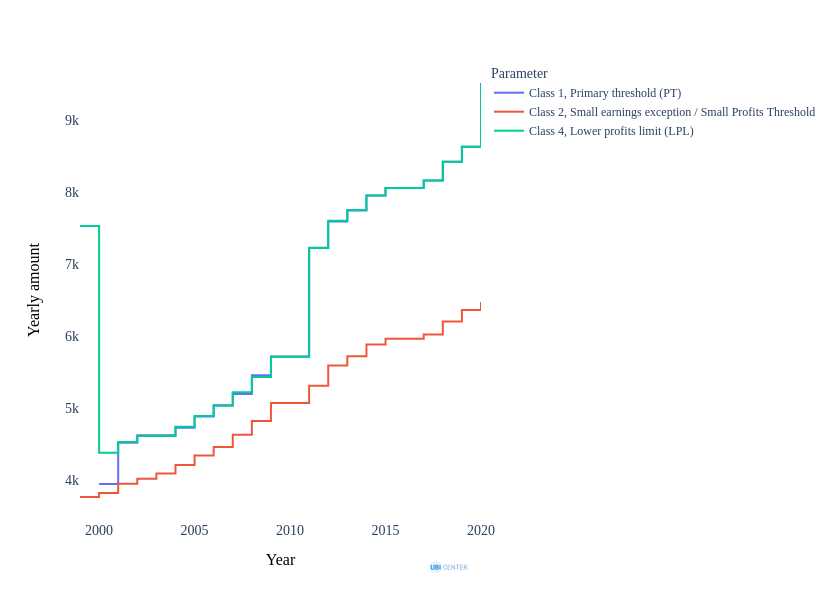

In [7]:
historical_NI = pd.read_csv("data/external/historical_NI.csv")
historical_NI["NICS Class"].fillna(method='ffill', inplace=True)
historical_NI.index = list(map(lambda rate, cat: f"{cat}, {rate}", historical_NI["Rate type"], historical_NI["NICS Class"]))
historical_NI.drop(["Rate type", "NICS Class"], axis=1, inplace=True)
historical_NI.columns = list(range(1999, 2021))
historical_NI = historical_NI.T

def parse_value(x):
    try:
        if "£" in x:
            return float(x[1:].replace(",", ""))
        elif "%" in x:
            return float(x[:-1]) / 100
    except:
        return None

historical_NI = historical_NI.apply(lambda col: col.apply(parse_value))
for column in historical_NI.columns:
    if "week" in column:
        historical_NI[column] *= 52
        
def cutoff_name(name):
    if "(" in name:
        name = "(".join(name.split("(")[:2]).rstrip()
    if "–" in name or "-" in name:
        name = name.split("-")[0].split("–")[0].rstrip()
    return name

historical_NI.columns = list(map(cutoff_name, historical_NI.columns))
historical_NI["Year"] = historical_NI.index

fig = format_fig(
    px.line(
        historical_NI,
        x="Year",
        y=[
           # 'Class 1, Lower earnings limit (LEL)',
           'Class 1, Primary threshold (PT)',
           # 'Class 1, Secondary threshold (ST)',
           #'Class 1, Upper Secondary Threshold (under 21)',
           #'Class 1, Apprentice Upper Secondary Threshold (apprentice under 25)',
           #'Class 1, Upper accruals Point (UAP)',
         #  'Class 1, Upper earnings limit (UEL)',
           'Class 2, Small earnings exception / Small Profits Threshold',
            'Class 4, Lower profits limit (LPL)',
           #'Class 4, Upper profits limit (UPL)',
           # 'Class 2, Flat',
           #'Class 3, Flat', 
        ],
        line_shape="hv"
    ).update_layout(
        legend_title="Parameter",
        yaxis_title="Yearly amount"
    ), show=False
)     
fig.write_image(IMAGES / "fig_6.png")
fig

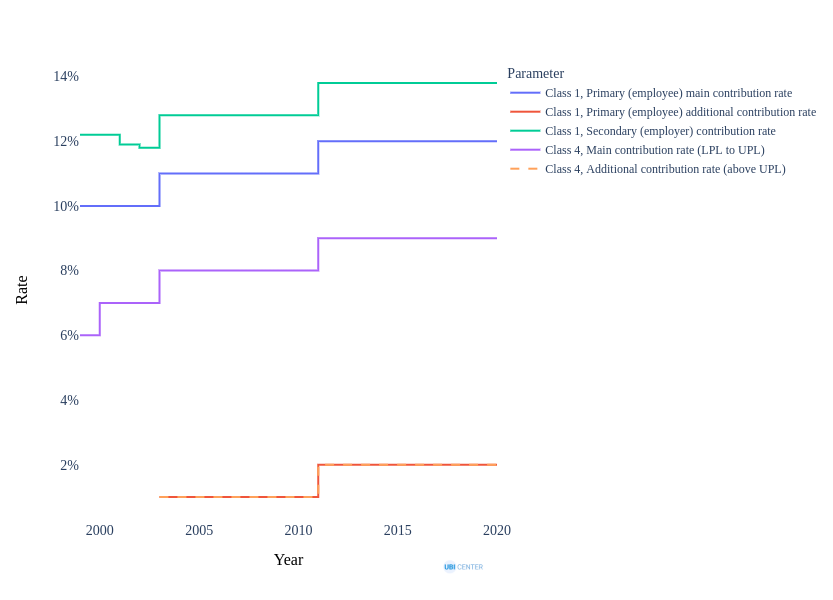

In [8]:
show_columns = [
          #  'Class 1A and 1B, Contribution rate  (note 10)', 
           'Class 1, Primary (employee) main contribution rate',
           'Class 1, Primary (employee) additional contribution rate',
           'Class 1, Secondary (employer) contribution rate',
          # 'Class 1, Primary (employee) reduced rate for married women and widow optants',
          # 'Class 1, Primary (employee) contracted out rebate',
           'Class 4, Main contribution rate (LPL to UPL)',
           'Class 4, Additional contribution rate (above UPL)'
        ]


fig = format_fig(
    px.line(
        historical_NI,
        x="Year",
        y=show_columns,
        line_shape="hv",
    ).update_layout(
        legend_title="Parameter",
        yaxis_title="Rate",
        yaxis_tickformat="%"
    ), show=False
)
fig.update_traces(patch={"line": {"dash": 'dash'}}, selector={"legendgroup": "Class 4, Additional contribution rate (above UPL)"})
fig.write_image(IMAGES / "fig_7.png")
fig

The current system provides a lower tax burden for the self-employed - NI (and total tax) contributions are lower at most points in the income spectrum, except for a region caused by the flat rate of Class 2 contributions. This also makes no assumption about how employer contributions affect employee pay.

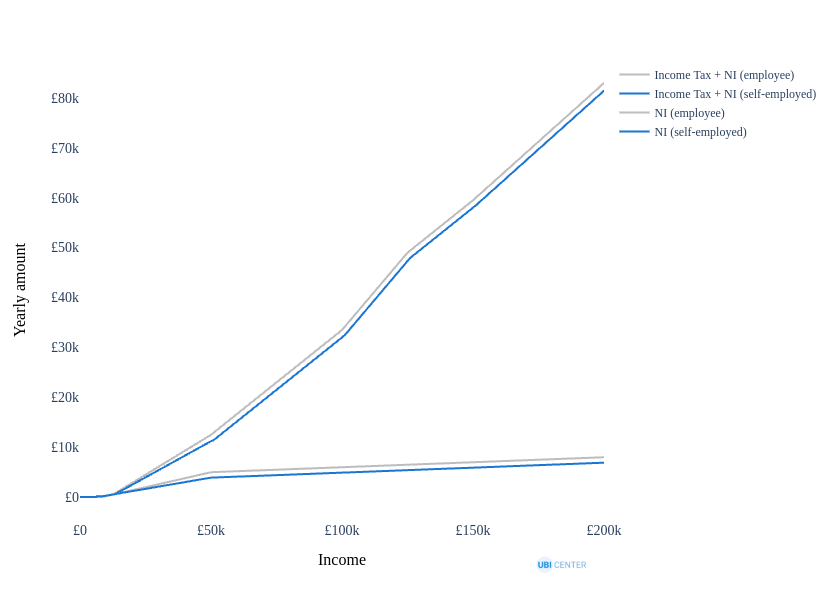

In [9]:
def self_employed_person(sim):
    sim.add_person(age=26)
    sim.vary("trading_income")
    return sim
def employee(sim):
    sim.add_person(age=26)
    sim.vary("employment_income")
    return sim

self_emp = self_employed_person(IndividualSim())
emp = employee(IndividualSim())

df = pd.DataFrame({
    "Income": emp.calc("employment_income")[0],
    "Income Tax + NI (employee)": emp.calc("tax")[0],
    "Income Tax + NI (self-employed)": self_emp.calc("tax")[0],
    "NI (employee)": emp.calc("national_insurance")[0],
    "NI (self-employed)": self_emp.calc("national_insurance")[0],
})
fig = format_fig(px.line(df, x="Income", y=["Income Tax + NI (employee)", "Income Tax + NI (self-employed)", "NI (employee)", "NI (self-employed)"],
    color_discrete_sequence=[GRAY, BLUE]).update_layout(
    yaxis_title="Yearly amount",
    yaxis_tickprefix="£",
    xaxis_tickprefix="£",
    legend_title="",
), show=False)

fig.write_image(IMAGES / "fig_8.png")
fig

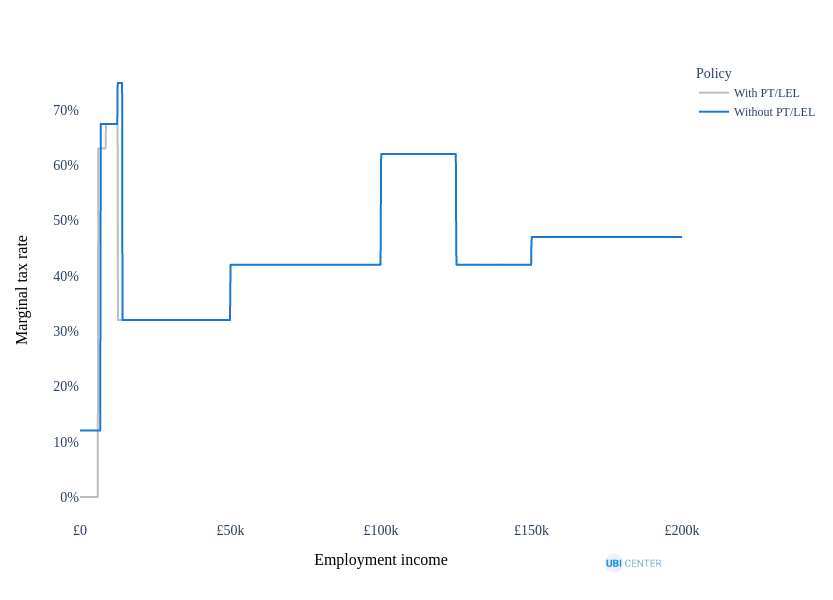

In [10]:
from openfisca_uk import IndividualSim, reforms
from openfisca_uk.situation_examples.examples import single_person_UC
from ubicenter.plotly import BLUE, GRAY
from openfisca_uk_data import FRS_SPI_Adjusted

NI_allowance_abolish = (
    reforms.parametric.set_parameter("tax.national_insurance.class_1.thresholds.primary_threshold", 0), 
    reforms.parametric.set_parameter("tax.national_insurance.class_4.thresholds.lower_profits_limit", 0),
)

budget, mtr = get_hypothetical_plots((), NI_allowance_abolish, reform_name = "Without PT/LEL", base_name = "With PT/LEL")
mtr.write_image(IMAGES / "fig_9.png")
mtr.show()

The removal of zero-rated parts of National Insurance would entail setting the Primary Threshold and the Lower Profits Limt to zero. Lowering the Small Earnings Exception, above which a flat rate of £3.05 per week is mandated, is therefore not necessary. This reform generates the following static estimated effects[^1]:

[^1]: Note that while individuals of State Pension Age are not liable for National Insurance, their poverty status can still be altered if they live in a household close to the poverty line with any other person who is liable for NI.

### UBI Replacement

A UBI replacement from the funding raised would have the following effects:

In [11]:
NI_UBI_reform = fund_UBI_from(
    (
        reforms.parametric.set_parameter("tax.national_insurance.class_1.thresholds.primary_threshold", 0), 
        reforms.parametric.set_parameter("tax.national_insurance.class_4.thresholds.lower_profits_limit", 0),
    )
)

results = evaluate_reform(NI_UBI_reform, Microsimulation(
                dataset=FRS_SPI_Adjusted
               ),)

save(results, "NI_results")
results

Absolute Relative
Category       Metric                               
Distributional Gini coefficient        -0.6    -1.4%
               P90/P10                 -0.3    -4.9%
               Top 10% share         -0.2pp    -0.6%
Poverty        Overall rate          -1.4pp   -10.3%
               Deep poverty rate     -0.5pp   -19.6%
               Adult poverty rate    -0.8pp    -7.4%
               Senior poverty rate   -2.0pp   -12.3%
               Child poverty rate    -2.7pp   -13.9%
               Poverty gap          £-2.6bn   -13.1%
Fiscal         Tax revenue          £29.1bn    12.9%
               Benefit spending     £29.1bn    15.3%
Overall        Winners                53.3%       -%
               Losers                 46.3%       -%

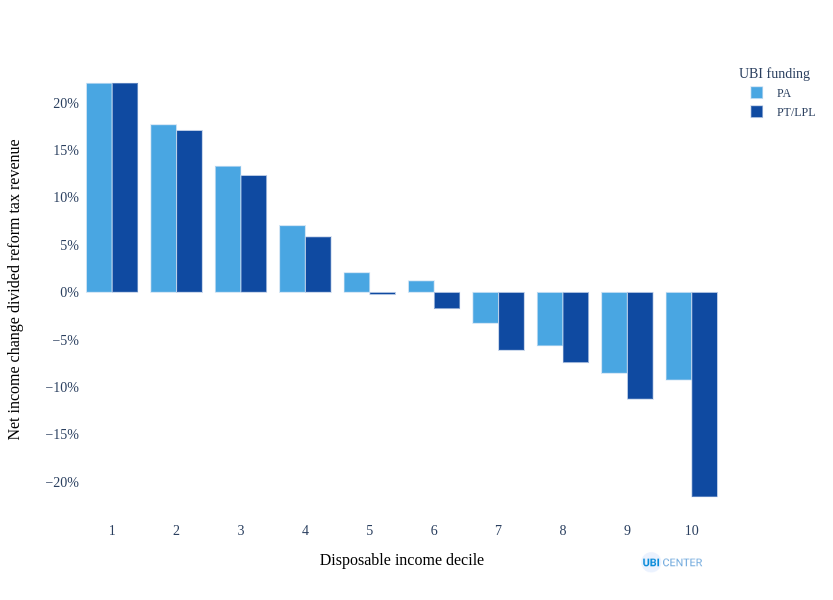

In [21]:
baseline = Microsimulation(dataset=FRS_SPI_Adjusted)
PA_UBI_reformed = Microsimulation(PA_UBI_reform, dataset=FRS_SPI_Adjusted)
NI_UBI_reformed = Microsimulation(NI_UBI_reform, dataset=FRS_SPI_Adjusted)
income = baseline.calc("equiv_household_net_income", map_to="person")
UBI_size = lambda sim: sim.calc("UBI").sum()
gain = lambda sim: sim.calc("household_net_income", map_to="person") - baseline.calc("household_net_income", map_to="person")
decile = income.decile_rank()
df = pd.DataFrame({
    "PA": gain(PA_UBI_reformed).groupby(decile).sum() / UBI_size(PA_UBI_reformed),
    "PT/LPL": gain(NI_UBI_reformed).groupby(decile).sum() / UBI_size(NI_UBI_reformed)
})
from ubicenter.plotly import LIGHT_BLUE, DARK_BLUE
fig = format_fig(px.bar(df, barmode="group", color_discrete_sequence=[LIGHT_BLUE, DARK_BLUE]).update_layout(
    yaxis_tickformat="%",
    yaxis_title="Net income change divided reform tax revenue",
    xaxis_tickvals=list(range(1, 11)),
    xaxis_title="Disposable income decile",
    legend_title="UBI funding"
), show=False)
fig.write_image(IMAGES / "fig_10.png")
fig

In [13]:
small_reforms = (
    reforms.structural.abolish("dividend_allowance"),
    reforms.structural.abolish("property_allowance"),
    reforms.structural.abolish("trading_allowance"),
    (
        reforms.parametric.set_parameter("benefit.universal_credit.means_test.earn_disregard", 0),
        reforms.parametric.set_parameter("benefit.universal_credit.means_test.earn_disregard_with_housing", 0),
        reforms.parametric.set_parameter("benefit.tax_credits.means_test.income_threshold", 0),
        reforms.parametric.set_parameter("benefit.tax_credits.means_test.income_threshold_CTC_only", 0)
    )
)
names = ("Dividends", "Property", "Trading", "Work")

results = []
for reform, name in zip(small_reforms, names):
    res = evaluate_reform(fund_UBI_from(reform), Microsimulation(
                dataset=FRS_SPI_Adjusted
               ),)
    results += [pd.concat([res["Relative"][:-2], res["Absolute"][-2:]])]
df = pd.concat(results, axis=1)
df = df.apply(lambda col: col.apply(lambda x: round(float(x[:-1]), 1)))
df.columns = names
df.reset_index(inplace=True)
df.Metric = [
    'Gini coefficient',
    'P90/P10',
    'Top 10% share',
    'Overall rate',
    'Deep poverty rate',
    'Adult poverty rate',
    'Senior poverty rate',
    'Child poverty rate',
    'Poverty gap',
    'Tax revenue',
    'Benefit spending',
    'Winners',
    'Losers'
]


results = df.set_index(["Category", "Metric"])
save(results, "small_results")

Dividends  Property  Trading  Work
Category       Metric                                                 
Distributional Gini coefficient          -0.1      -0.0     -0.0   0.5
               P90/P10                   -0.1      -0.0     -0.1  -0.2
               Top 10% share             -0.1      -0.1     -0.0   0.1
Poverty        Overall rate              -0.2      -0.1      0.1   8.0
               Deep poverty rate         -0.3      -0.2      0.2  -3.6
               Adult poverty rate        -0.2      -0.2      0.2   9.4
               Senior poverty rate       -0.4      -0.1     -0.8  -3.6
               Child poverty rate        -0.2      -0.0      0.5  13.6
               Poverty gap               -0.2      -0.2     -0.2   3.0
Fiscal         Tax revenue                0.4       0.1      0.3   0.0
               Benefit spending           0.5       0.2      0.3   0.0
Overall        Winners                   79.3      95.0     88.9  82.5
               Losers                    20.2       4.5     10.6  17.0

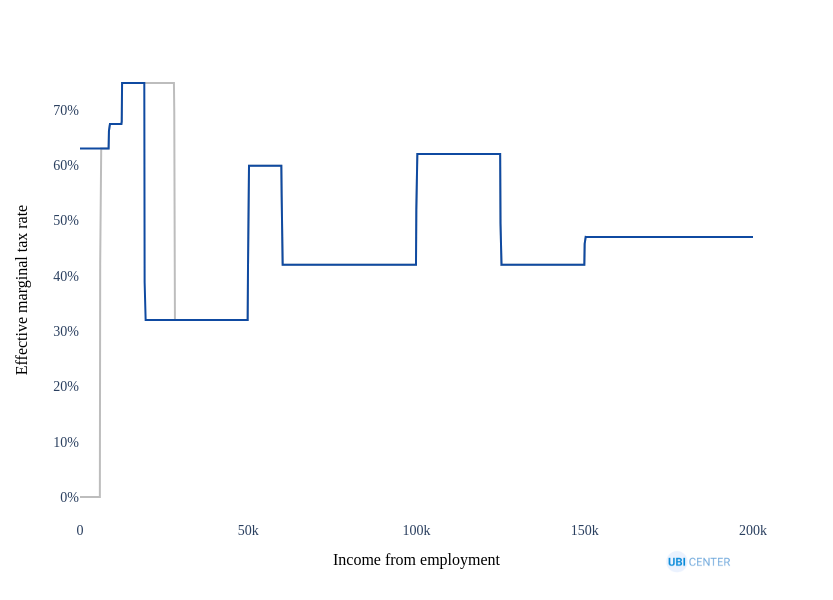

In [14]:
from openfisca_uk.situation_examples.examples import *
def single_person_UC_two_children(sim):
    sim.add_person(
        name="adult", age=26, is_household_head=True, is_benunit_head=True
    )
    sim.add_person(name="child", age=4)
    sim.add_person(name="child_2", age=6)
    sim.add_benunit(
        adults=["adult"], children=["child", "child_2"], claims_UC=True, claims_child_benefit=True,
    )
    sim.add_household(adults=["adult"], children=["child", "child_2"])
    return sim
fig = format_fig(
    graphs.mtr_chart(small_reforms[-1], situation_function=single_person_UC_two_children).update_layout(
    yaxis_title="Effective marginal tax rate",
    showlegend=False,
), show=False)
fig.write_image(IMAGES / "fig_11.png")
fig

In [15]:
baseline = Microsimulation(dataset=FRS_SPI_Adjusted)
column_names = [
        "UBI (£/year)",
        "Household UBI (£/year)",
        "Expenditure (£bn)",
        "Poverty gap change (£bn)",
        "Poverty gap efficiency (%)"
    ]
def get_reform_series(reform):
    reformed = Microsimulation(reform, dataset=FRS_SPI_Adjusted)
    UBI_value = reformed.calc("UBI").max()
    household_UBI = reformed.calc("UBI", map_to="household").mean()
    expenditure = reformed.calc("UBI").sum() / 1e+9
    poverty_gap_change = (reformed.calc("poverty_gap_bhc").sum() - baseline.calc("poverty_gap_bhc").sum()) / 1e+9
    return pd.Series([
        round(UBI_value, 1),
        round(household_UBI, 1),
        round(expenditure, 1),
        round(poverty_gap_change, 1),
        round(-poverty_gap_change / expenditure * 1e+2, 1)
    ], index=column_names)

df = pd.DataFrame()
UBI_reforms = list(map(fund_UBI_from, (
    reforms.structural.abolish("personal_allowance"),
    NI_allowance_abolish,
    *small_reforms,
    (
        reforms.structural.abolish("personal_allowance"),
        NI_allowance_abolish,
        *small_reforms,
    ),
    (
        reforms.structural.abolish("personal_allowance"),
        NI_allowance_abolish,
        *small_reforms[:-1],
    ),
)))
names = (
    "Personal Allowance",
    "Primary Threshold & LPL",
    "Dividend Allowance",
    "Property Allowance",
    "Trading Allowance",
    "Work Allowances",
    "Combined",
    "Combined (excl. Work Allowances)"
)
for reform, name in zip(UBI_reforms, names):
    df[name] = get_reform_series(reform)
df = df.T.apply(lambda col: col.apply(lambda x: round(x, 2))).sort_values("Poverty gap efficiency (%)", ascending=False)
save(df[column_names[:3]], "comp_table_1")
save(df[column_names[3:]], "comp_table_2")
df

UBI (£/year)  Household UBI (£/year)  \
Property Allowance                         5.2                    12.2   
Primary Threshold & LPL                  418.1                   983.8   
Personal Allowance                      1501.9                  3533.9   
Combined (excl. Work Allowances)        1947.4                  4582.0   
Combined                                2082.6                  4900.1   
Dividend Allowance                        14.0                    32.8   
Trading Allowance                         10.1                    23.8   
Work Allowances                          114.3                   268.9   

                                  Expenditure (£bn)  Poverty gap change (£bn)  \
Property Allowance                              0.3                      -0.0   
Primary Threshold & LPL                        27.4                      -2.6   
Personal Allowance                             98.3                      -7.2   
Combined (excl. Work Allowances)              127.5                      -9.0   
Combined                                      136.4                      -9.2   
Dividend Allowance                              0.9                      -0.0   
Trading Allowance                               0.7                      -0.0   
Work Allowances                                 7.5                       0.6   

                                  Poverty gap efficiency (%)  
Property Allowance                                      11.9  
Primary Threshold & LPL                                  9.6  
Personal Allowance                                       7.3  
Combined (excl. Work Allowances)                         7.1  
Combined                                                 6.7  
Dividend Allowance                                       5.5  
Trading Allowance                                        5.0  
Work Allowances                                         -8.0

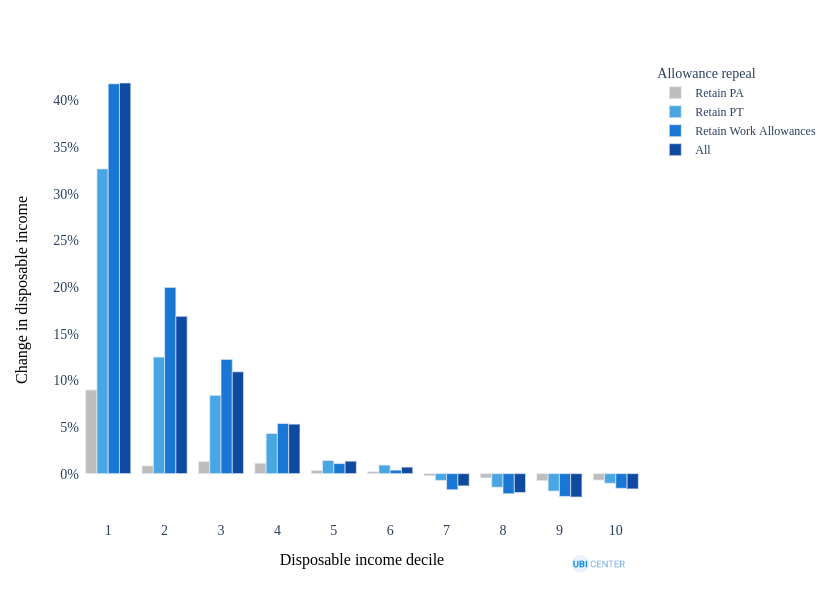

In [16]:
combined = (
        reforms.structural.abolish("personal_allowance"),
        NI_allowance_abolish,
        *small_reforms,
    )
combined_without_ben = (
        reforms.structural.abolish("personal_allowance"),
        NI_allowance_abolish,
        *small_reforms[:-1],
    )
combined_without_PA = combined[1:]
combined_without_PT = (
        reforms.structural.abolish("personal_allowance"),
        *small_reforms,
    )

baseline = Microsimulation(dataset=FRS_SPI_Adjusted)
income = baseline.calc("equiv_household_net_income", map_to="person")
UBI_size = lambda sim: sim.calc("UBI").sum()
gain = lambda sim: sim.calc("household_net_income", map_to="person") - baseline.calc("household_net_income", map_to="person")
decile = income.decile_rank()
df = pd.DataFrame()
for reform, name in zip([combined, combined_without_ben, combined_without_PT, combined_without_PA][::-1], [
    "All",
    "Retain Work Allowances",
    "Retain PT",
    "Retain PA",
][::-1]):
    sim = Microsimulation(fund_UBI_from(reform), dataset=FRS_SPI_Adjusted)
    df[name] = gain(sim).groupby(decile).sum() / income.groupby(decile).sum()
from ubicenter.plotly import LIGHT_BLUE, DARK_BLUE
fig = format_fig(px.bar(df, barmode="group", color_discrete_sequence=[GRAY, LIGHT_BLUE, BLUE, DARK_BLUE]).update_layout(
    yaxis_title="Change in disposable income",
    xaxis_tickvals=list(range(1, 11)),
    xaxis_title="Disposable income decile",
    legend_title="Allowance repeal",
    yaxis_tickformat="%"
), show=False)
fig.write_image(IMAGES / "fig_13.png")
fig